In [1]:
#import libraries
#import necessary libraries
import matplotlib.pyplot as plt
import torch
import optuna
import torch.optim as optim
from optuna import TrialPruned
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import requests
from pathlib import Path
from helper_functions import accuracy_fn

In [2]:
# Define the root directory where your dataset is located
train_root_directory = "Data/train"
test_root_directory = "Data/test"
valid_root_directory = "Data/valid"

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust as needed
    transforms.ToTensor(),
])

# Use ImageFolder to load the dataset
train_disease_dataset = ImageFolder(root=train_root_directory, transform=transform)
test_disease_dataset = ImageFolder(root=test_root_directory, transform=transform)
valid_disease_dataset = ImageFolder(root=valid_root_directory, transform=transform)

# Create a DataLoader for iterating through the dataset in batches
#batch_size = 32  # Adjust as needed
#data_loader = DataLoader(car_dataset, batch_size=batch_size, shuffle=True)

# Print the class labels assigned by ImageFolder
print("Class Labels:", train_disease_dataset.classes)


Class Labels: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']


In [ ]:
# check the distribution of the dataset classes

# Create a DataFrame with the class labels and the number of images in each class
class_distribution = pd.DataFrame({
    "class": train_disease_dataset.classes,
    "count": [0] * len(train_disease_dataset.classes)
})

# Count the number of images in each class
for _, label in train_disease_dataset:
    class_distribution.loc[label, "count"] += 1

# Plot the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=class_distribution, x="class", y="count")
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.title("Class Distribution")
plt.show()


In [3]:
#look at the class names
class_names = train_disease_dataset.classes
class_names

['Aphid',
 'Black Rust',
 'Blast',
 'Brown Rust',
 'Common Root Rot',
 'Fusarium Head Blight',
 'Healthy',
 'Leaf Blight',
 'Mildew',
 'Mite',
 'Septoria',
 'Smut',
 'Stem fly',
 'Tan spot',
 'Yellow Rust']

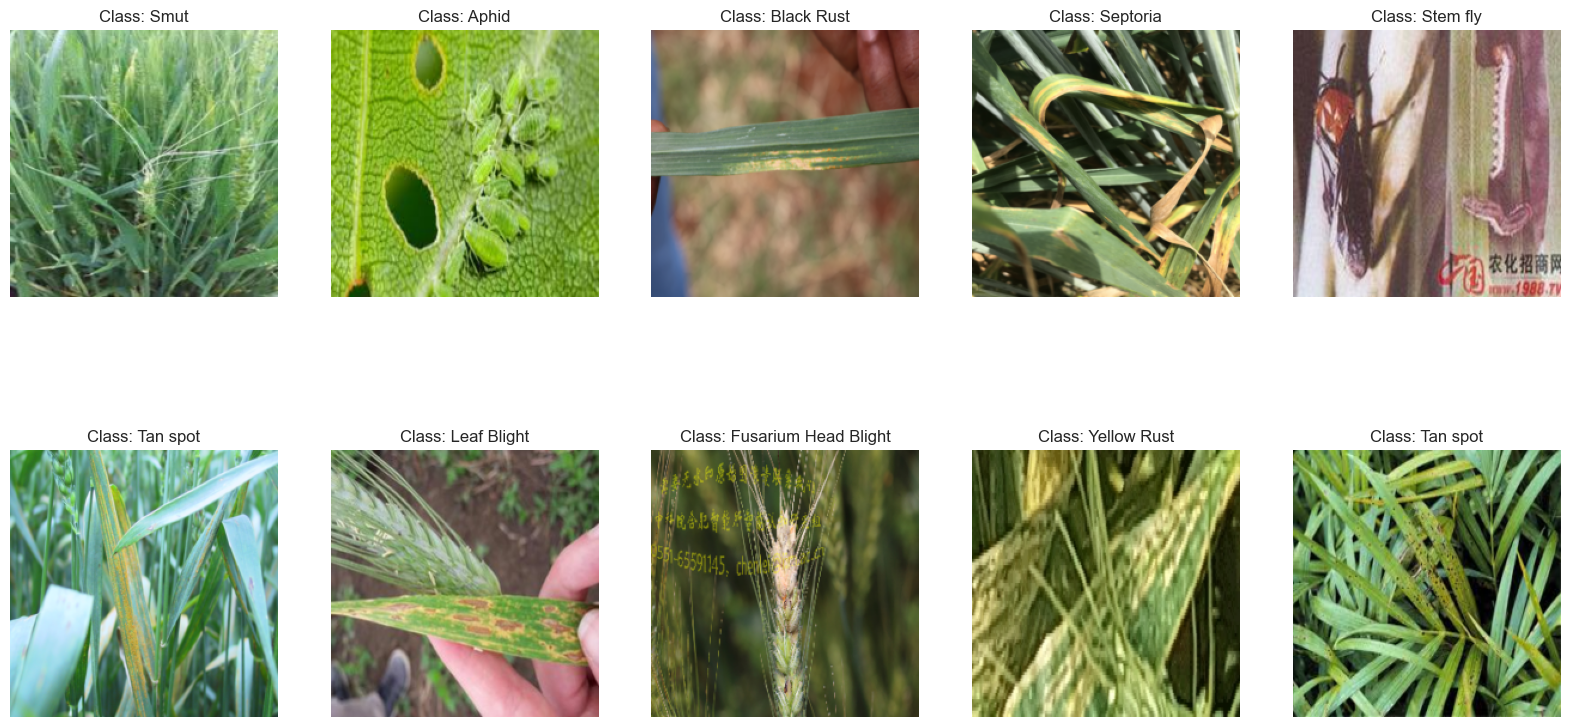

In [4]:
# plot 10 random images in the dataset
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    # Get a random image from the dataset
    index = np.random.randint(len(train_disease_dataset))
    image, label = train_disease_dataset[index]
    # Plot the image
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"Class: {class_names[label]}")
    ax.axis("off")
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LiquidDiseaseClassifier(nn.Module):
    def __init__(self, dropout_rate, batch_size, train_data, test_data, valid_data):
        super(LiquidDiseaseClassifier, self).__init__()
        # Define the dataloaders
        self.train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        self.test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
        self.val_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

        # Input shape: 3 * 224 * 224
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # Shape after conv1: 6 * 220 * 220
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Shape after pool: 6 * 110 * 110

        # Reservoir
        self.reservoir_size = 100
        self.W_in = nn.Linear(in_features=6 * 110 * 110, out_features=self.reservoir_size)
        self.W_res = nn.Linear(in_features=self.reservoir_size, out_features=self.reservoir_size)

        # Readout
        self.fc1 = nn.Linear(in_features=self.reservoir_size, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=15)

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.batch_norm1 = nn.BatchNorm1d(self.reservoir_size)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 6 * 110 * 110)

        # Initialize reservoir
        reservoir = torch.zeros((x.size(0), self.reservoir_size), device=x.device)

        # Compute reservoir dynamics
        for i in range(10):  # Adjust the number of iterations as needed
            x = torch.tanh(self.W_in(x) + self.W_res(reservoir))
            reservoir = x

        x = F.relu(self.fc1(reservoir))
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = self.fc3(x)
        x = self.dropout2(x)
        x = self.softmax(x)
        return x


In [16]:
# setup loss function
loss_fn = nn.CrossEntropyLoss()
#device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
def train_step(
        model: torch.nn.Module,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        accuracy_fn,
        device: torch.device = device):
    """Performs a training with model trying to learn on data_loader."""
    train_loss, train_acc = 0, 0

    # Put model into training mode
    model.train()

    # Add a loop through the training batches
    for batch, (X, y) in enumerate(model.train_dataloader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        # Initialize reservoir
        reservoir = torch.zeros((X.size(0), model.reservoir_size))

        # Compute reservoir dynamics
        for i in range(10):  # Adjust the number of iterations as needed
            X = torch.tanh(model.W_in(X) + model.W_res(reservoir))
            reservoir = X

        # Readout
        train_pred = model.fc1(reservoir)
        train_pred = model.fc2(train_pred)
        train_pred = model.fc3(train_pred)

        # Calculate loss and accuracy
        loss = loss_fn(train_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=train_pred.argmax(dim=1))

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step (update the model's parameters once *per batch*)
        optimizer.step()

    # Divide total train
    train_loss /= len(model.train_dataloader)
    train_acc /= len(model.train_dataloader)

    # Save the train accuracy and loss history
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss.item())
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

    return train_acc, train_loss  # , train_acc_history, train_loss_history

In [18]:
def test_step(
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0
  
  # Put the model in eval mode
  model.eval()
  
  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)
      
      # Initialize reservoir
      reservoir = torch.zeros((X.size(0), model.reservoir_size))
      
      # Compute reservoir dynamics
      for i in range(10):  # Adjust the number of iterations as needed
        X = torch.tanh(model.W_in(X) + model.W_res(reservoir))
        reservoir = X
      
      # Readout
      test_pred = model.fc1(reservoir)
      test_pred = model.fc2(test_pred)
      test_pred = model.fc3(test_pred)
      
      # Calculate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))  # go from logits -> prediction labels
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test_acc: {test_acc:.2f}%\n")
    
    # Save the test accuracy and loss history
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss.item())
    
    return test_acc, test_loss  #, test_acc_history, test_loss_history

In [19]:
def val_step(
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device = device):
  """Performs a validation loop step on model going over data_loader."""
  val_loss, val_acc = 0, 0
  
  # Put the model in eval mode
  model.eval()
  
  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)
      
      # Initialize reservoir
      reservoir = torch.zeros((X.size(0), model.reservoir_size))
      
      # Compute reservoir dynamics
      for i in range(10):  # Adjust the number of iterations as needed
        X = torch.tanh(model.W_in(X) + model.W_res(reservoir))
        reservoir = X
      
      # Readout
      test_pred = model.fc1(reservoir)
      test_pred = model.fc2(test_pred)
      test_pred = model.fc3(test_pred)
      
      # Calculate the loss/acc
      val_loss += loss_fn(test_pred, y)
      val_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))  # go from logits -> prediction labels
      
    # Adjust metrics and print out
    val_loss /= len(data_loader)
    val_acc /= len(data_loader)
    print(f"\nValidation loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.2f}%\n")
    
    return val_acc, val_loss

In [20]:
def objective(trial):
    # Create the LNN model with the suggested dropout rate
    model = LiquidDiseaseClassifier(dropout_rate=trial.suggest_float("dropout_rate", 0.1, 0.5),
                                   batch_size=trial.suggest_categorical("batch_size", [16, 32, 64]),
                                   train_data=train_disease_dataset,
                                   test_data=test_disease_dataset,
                                   valid_data=valid_disease_dataset)
    
    # Learning rate and optimizer trials
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    
    # Create the optimizer with the suggested learning rate and optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Early stopping parameters
    patience = 5  # Number of epochs to wait before early stopping
    min_delta = 0.001  # Minimum change in validation loss to qualify as an improvement
    counter = 0
    best_loss = float('inf')
    
    # Training loop
    for epoch in range(3):  # Maximum number of epochs
        
        train_loss, train_acc = train_step(model, loss_fn, optimizer, accuracy_fn, device)
        test_acc, test_loss = test_step(model, loss_fn, accuracy_fn, model.test_dataloader, device)
        
        # Early stopping
        if test_loss < best_loss - min_delta:
            best_loss = test_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                raise TrialPruned()
        
        # Report intermediate values to Optuna
        trial.report(test_loss, epoch)
        
        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise TrialPruned()
    
    # Evaluate the model on the test set
    val_results = val_step(model, loss_fn, accuracy_fn, model.val_dataloader, device)
    val_acc, val_loss = val_results
    return val_acc

In [21]:
# Create a study object and optimize the objective function 
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2024-04-20 13:25:11,698] A new study created in memory with name: no-name-6afe8194-4907-45ba-9fb9-ccf41060bdcb
[W 2024-04-20 13:25:12,763] Trial 0 failed with parameters: {'dropout_rate': 0.41870478983571835, 'batch_size': 16, 'lr': 0.00010107273269652269, 'optimizer': 'Adam'} because of the following error: RuntimeError('mat1 and mat2 shapes cannot be multiplied (10752x224 and 72600x100)').
Traceback (most recent call last):
  File "/Users/julianmagnago/.local/share/virtualenvs/WheatDiseaseClassifier-I6OUpnKR/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/2k/c3p8y0j913z7nh8832f5clzw0000gn/T/ipykernel_97584/3322625656.py", line 31, in objective
    train_loss, train_acc = train_step(model, loss_fn, optimizer, accuracy_fn, device)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/2k/c3p8y0j913z7nh8832f5clz

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10752x224 and 72600x100)